# Exercise 1: Polynomial under- and overfitting

Consider the following non-linear model,
$$
\begin{aligned}
y_i &= f(x_i) + \epsilon_i \\
f(x) &= \cos\left(\frac{3}{2} \pi x \right) \\
\epsilon_i &\stackrel{\text{iid}}{\sim} N(0, \sigma_{\epsilon}^2)
\end{aligned}
$$
where $y_i$ is a trigonometric function of $x_i$ but is measured with an additive error $\epsilon_i$. In this exercise, we are going to approximate $y_i$ using polynomials in $x_i$ of varying degrees.

***
## Part 1: Creating and plotting a sample

The function `fcn()` implements the true relationship $y=f(x)$. 

In [1]:
import numpy as np

def fcn(x):
    """
    True function without errors
    """
    return np.cos(1.5 * np.pi * x)

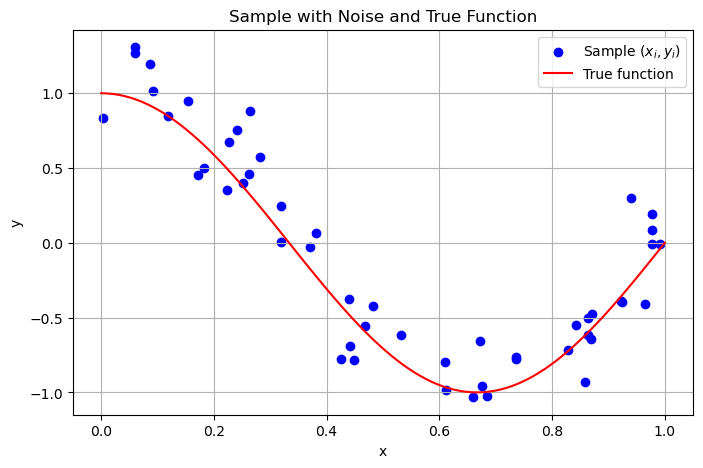

In [6]:
# Sample size
N = 50

# Set seed for reproducibility
from numpy.random import default_rng
rng = default_rng(seed = 1234)

# Sigma
sigma = 0.2

# Generate xi randomly drawn from a uniform distribution on the interval [0, 1]
xi = rng.uniform(0, 1, N)

# Epsilon
epsilon = rng.normal(0, sigma, N)  

# Generate yi = f(xi) + epsilon
yi = fcn(xi) + epsilon

# Plot the data
import matplotlib.pyplot as plt
x_true = np.linspace(0, 1, 100)
y_true = fcn(x_true)

plt.figure(figsize=(8, 5))
plt.scatter(xi, yi, label="Sample $(x_i, y_i)$", color='blue')
plt.plot(x_true, y_true, label="True function", color='red')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sample with Noise and True Function")
plt.legend()
plt.grid(True)
plt.show()

Using this function, create a sample of size $N=50$ where the $x_i$ are randomly drawn from a uniform distribution on the interval $[0, 1]$ and 
$\sigma_{\epsilon} = 0.2$ (initialize your RNG with a seed of 1234).
Then generate $y_i$ according to the equation given above. 

Create a scatter plot of the sample $(x_i, y_i)$ and add a line depicting the true relationship without measurement error.

***
## Part 2: Polynomial approximations

In order to approximate this relationship using polynomials, you first want to visualize how the polynomial degree affects the model fit. To this end, complete the template for `plot_poly_degree()` below to create a figure with 6 sub-plots,
each showing the predicted values for a polynomial of degree $d$, where $d \in \{0, 1, 2, 3, 10, 15\}$.
Each panel should additionally show the sample scatter plot and the true function $y = f(x)$.

How does the quality of the approximation change as you increase $d$? Do higher-order polynomials always perform better?

*Hints:* 

-   You should build a pipeline, e.g., using 
[`make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html),
which combines the 
[`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
transformation and 
[`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
to approximate $y$ as a polynomial in $x$.

-   When creating polynomials with `PolynomialFeatures(..., include_bias=True)`, you need to fit the model *without*
    an additional intercept as the intercept is already included in the polynomial.

In [20]:
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def plot_poly_degrees(degrees, X, y):
    """
    Fit and plot polynomial regression models of different degrees.

    Parameters
    ----------
    degrees : array-like
        List of polynomial degrees to fit and plot
    X : array-like
        Explanatory variable
    y : array-like
        Response variable
    """

    # Create figure with 3 columns
    ncol = 3
    nrow = int(np.ceil(len(degrees) / ncol))

    fig, axes = plt.subplots(
        nrow, ncol, figsize=(8, 5), sharex=True, sharey=True, constrained_layout=True
    )

    # x-values for predicting & plotting
    xvalues = np.linspace(0.0, 1.0, 101)
    # True y-values
    y_true = fcn(xvalues)

    for i, ax in enumerate(axes.flatten()):

        # Degree for current sub-plot
        d = degrees[i]

        # TODO: Create polynomial + estimation pipeline
        pipe = make_pipeline(PolynomialFeatures(degree=d, include_bias = True),
                              LinearRegression(fit_intercept = False))
        
        # TODO: Fit the model to the sample data
        pipe.fit(X, y)

        # TODO: Predict the response variable for the x-values
        y_pred = pipe.predict(xvalues[:, None])

        # TODO: Plot predicted values
        ax.plot(xvalues, y_pred, color='red', lw=1.0, label=f"Degree {d}")

        # Plot true relationship
        ax.plot(xvalues, y_true, color='black', lw=1.0)
        # Plot sample as scatter plot
        ax.scatter(X, y, s=20, color='none', edgecolor='steelblue', lw=0.75)
        ax.set_ylim((-1.5, 1.5))
        ax.legend()

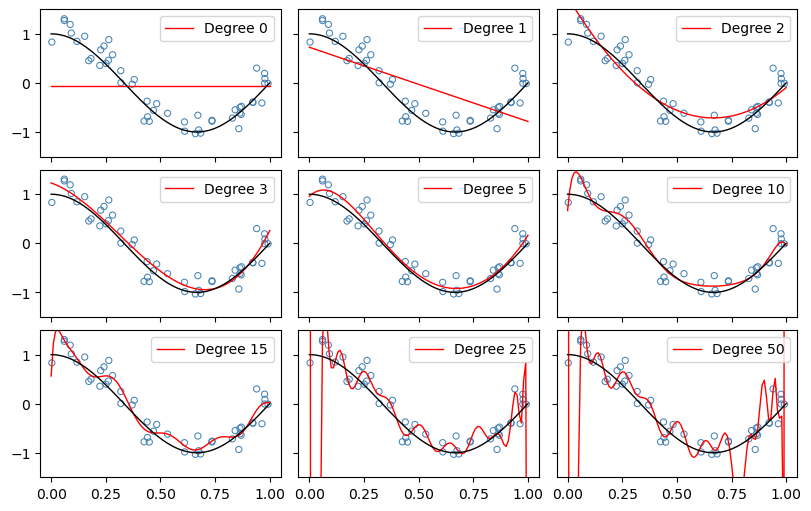

In [27]:
# Candidate degrees
degrees = [0, 1, 2, 3, 5, 10, 15, 25, 50]

# covert feature vector to matrix
X = xi[:, None]

# Plot polynomial regression models
plot_poly_degrees(degrees, X, yi)

***
## Part 3: Optimal polynomial degree with cross-validation

You want to find the optimal polynomial degree using cross-validation. To this end,
implement the function `compute_average_mse()` using the template below.

This function takes as arguments the polynomial degree $d$, the 
sample observations $(X, y)$ and the number of splits `n_splits`, and returns the mean squared error (MSE) for the
training and test samples averaged across all splits. 

*Hint:* To compute the MSE for each test sample, you can use 
[`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def compute_average_mse(d, X, y, n_splits=10):
    """
    Compute mean squared error averaged across splits in k-fold cross-validation.

    Parameters
    ----------
    d : int
        Degree of polynomial
    x : array-like
        Explanatory variable
    y : array-like
        Response variable
    n_splits : int
        Number of splits in k-fold cross-validation

    Returns
    -------
    mse_train : array-like
        Average MSE on training sample over all splits
    mse_test : array-like
        Average MSE on test sample over all splits
    """

    # TODO: create polynomial + estimation pipeline
    pipe = make_pipeline(PolynomialFeatures(degree=d, include_bias = True),
                         LinearRegression(fit_intercept = False))

    # Split sample into train/test blocks for k-fold validation
    kf = KFold(n_splits=n_splits)

    # list to store MSE for each CV split
    mse_train_splits = []
    mse_test_splits = []

    # Manually iterate over folds (train/test combinations)
    for itrain, itest in kf.split(X):

        # Extract training and test data for current split
        X_train = X[itrain]
        X_test = X[itest]

        y_train = y[itrain]
        y_test = y[itest]

        # TODO: Fit the model to current training data
        pipe.fit(X_train, y_train)

        # TODO: Predict the response variable on both the training and test data
        y_train_pred = pipe.predict(X_train)
        y_test_pred = pipe.predict(X_test)
        
        # TODO: Compute the mean squared error for both the training and test data
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        
        # TODO: Append the MSE to mse_train_splits and mse_test_splits
        mse_train_splits.append(mse_train)
        mse_test_splits.append(mse_test)

    # Compute average MSE over all splits
    mse_train = np.mean(mse_train_splits)
    mse_test = np.mean(mse_test_splits)

    return mse_train, mse_test


In [31]:
compute_average_mse(0, X, yi)

(np.float64(0.46922813114064016), np.float64(0.4952176940635251))

***
## Part 4: Computing the MSE for each hyperparameter

Using the function you wrote, compute the average MSEs for a sequence of 16 polynomial degrees $d = 0, 1, 2, \dots, 15$ using 10 splits.
Use the MSE statistics to plot the validation curve showing the average MSE on the $y$-axis against $d$ on the $x$-axis.
Which degree $d$ results in the lowest average MSE on the test sample? 

In [35]:
degrees = np.arange(0,16)

mse_train_mean = []
mse_test_mean = []

for d in degrees:
    mse_train, mse_test = compute_average_mse(d, X, yi)
    mse_train_mean.append(mse_train)
    mse_test_mean.append(mse_test)

In [36]:
imin = np.argmin(mse_test_mean)
dmin = degrees[imin]

print(f"Degree with minimum test error: {dmin}")

Degree with minimum test error: 4


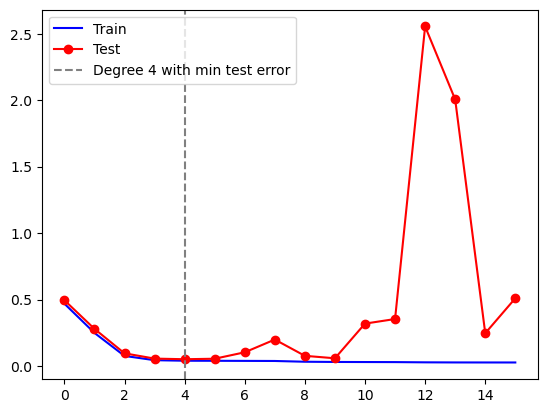

In [38]:
plt.plot(degrees, mse_train_mean, label="Train", c = 'blue')
plt.plot(degrees, mse_test_mean, label="Test", c = 'red', marker = 'o') 
plt.axvline(dmin, color='gray', linestyle='--', label=f"Degree {dmin} with min test error")
plt.legend()

***
## Part 5: Plotting the fitted model

Re-estimate the model using the optimal polynomial degree you just found and create a scatter plot with the original data, the true function $y = f(x)$, and the fitted polynomial.

***
## Part 6: Automatic cross-validation  with validation curves


You recall from the lecture that the steps in Parts (3) and (4) can be implemented in an easier way using
[`validation_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html).
Re-implement the cross-validation using this function by completing the code template below. 

*Hint:* Don't forget that you have to use
the *negative* MSE as the relevant criterion, i.e., specify the argument
`scoring='neg_mean_squared_error'` when calling `validation_curve()`.

In [ ]:
from sklearn.model_selection import validation_curve

# TODO: Create estimation pipeline

# TODO: Complete the call to validation_curve()
# train_scores, test_scores = validation_curve(
#     estimator=...,
#     X=X, y=y,
#     param_name=...,
#     param_range=...,
#     scoring=..., 
#     cv=10
# )

# TODO: Average train_scores and test_scores across CV splits

# TODO: Report the polynomial degree that minimizes the MSE on the test sample

***
# Exercise 2: Categorical features

In this exercise, we practice fitting models which include categorical features in the regressor matrix $\mathbf{X}$ using the Ames housing data set. There are several categorical variables in this data which come in two different kinds:

1.  [Nominal categorical variables](https://en.wikipedia.org/wiki/Nominal_category) capture qualitative categories. For numerical purposes, we often encode these as integer values, but any particular
    integer representation is arbitrary. It is a serious mistake to include such integer-valued categorical variables as *continuous* features in a model.

    In the Ames housing data, the `Neighborhood` column is one such nominal categorical variable (which is stored as a string containing the neighborhood name).

2.  [Ordinal categorical variables](https://en.wikipedia.org/wiki/Ordinal_data) represent data which have a natural ordering, but the distance between any two values can be arbitrary.
    
    For example, in the Ames housing data the `OverallQuality` variable is an ordinal categorical variable on a scale of 1–10. While a value of 2 is clearly better than a value of 1, it is up to
    interpretation how much better.

    Such variables can be included as categorical *dummy variables* in a model, not imposing any particular interpretation on the distance between two values. Alternatively, such variables can 
    be included as *continuous* variables, which imposes how the distance is interpreted. For example, including an ordinal categorical variable as a linear term in a model imposes
    that moving from 1 to 2 has the same effect on the outcome variable as moving from 2 to 3.

***
## Part 1: Creating the estimation sample

We load the Ames data the same way as we did in the lectures:

In [39]:
import pandas as pd

# Use local data/ folder
DATA_PATH = '../../data'

filename = f'{DATA_PATH}/ames_houses.csv'
df = pd.read_csv(filename, sep=',')

First, perform the following data preprocessing steps:

1.   Drop all observations which have any missing values for `SalePrice`, `OverallQuality`, or `Neighborhood`.
2.   Tabulate how many neighborhoods have less than 40 observations, and drop observations from these neighborhoods from the data set.

In [45]:
columns =  ['SalePrice','OverallQuality','Neighborhood']

# Drop all missing values
df = df.dropna(subset=columns)


In [47]:
nobs = df['Neighborhood'].value_counts().sort_values()

In [48]:
nobs = df.groupby('Neighborhood').transform('size')
df = df.loc[nobs >= 40]
len(df)

2767

***
## Part 2: Exploratory data analysis

Before fitting a model, you should perform some exploratory data analysis to familiarize yourself with the data:

1.  Compute the correlations of `SalePrice` with all numerical variables in the data. Which one is the most correlated?
2.  Create a histogram for the variable `OverallQuality`, showing the number of observations for each of the possible values 1–10.

    *Hint:* Create a `Series` with the number of observations per quality level and plot it as a bar chart using 
        [Series.plot.bar()](https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.bar.html).

3.  Create a box plot showing the `SalePrice` by `OverallQuality`. 

    *Hint:* You can use the pandas plotting function [DataFrame.plot.box()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.box.html)
    for this.

4.  Create a box plot showing the `SalePrice` by `Neighborhood`. 

SalePrice    Axes(0.125,0.11;0.775x0.77)
dtype: object

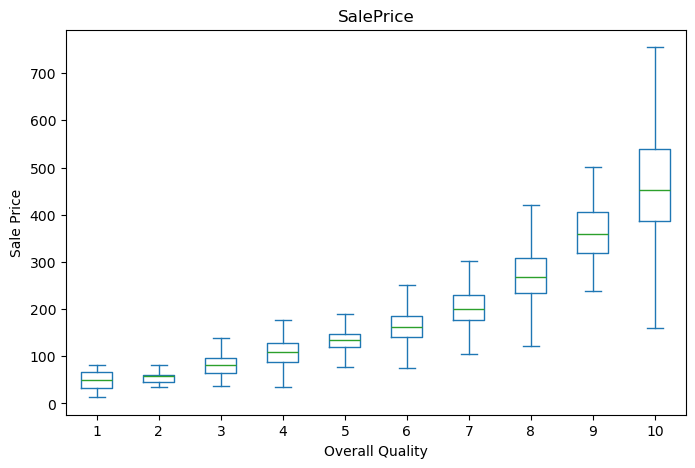

In [57]:
# Boxplot
df.plot.box(by = 'OverallQuality', 
            column = 'SalePrice',
            showfliers = False,
            xlabel = 'Overall Quality',
            ylabel = 'Sale Price',
            figsize=(8, 5))

SalePrice    Axes(0.125,0.11;0.775x0.77)
dtype: object

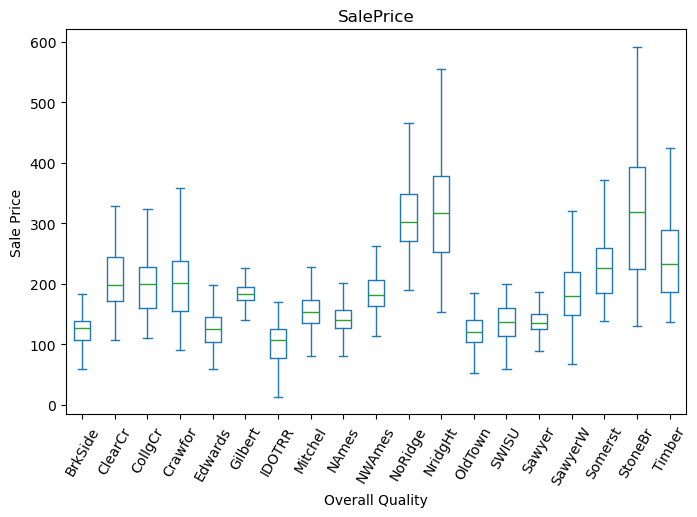

In [59]:
# Boxplot
df.plot.box(by = 'Neighborhood', 
            column = 'SalePrice',
            showfliers = False,
            xlabel = 'Overall Quality',
            ylabel = 'Sale Price',
            rot = 60,
            figsize=(8, 5))

***
## Part 3: Train-test split

Split the data into a training and a test sample, assigning 40% of observations to the test sample, and report the number of observations in each set.

Stratify your split by `Neighborhood` so that each neighborhood is approximately equally represented in the training and test samples 
(use the `stratify` argument of 
[`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for this).
Specify a random seed of 1234.

Note that you can pass the whole `DataFrame` to `train_test_split()` instead of individual `X` and `y` values.
The function will then return two DataFrames, one containing the training and one the test data.

In [61]:
from sklearn.model_selection import train_test_split

test_size = 0.4

# Split the data into training and test sets
df_train, df_test = train_test_split(df, test_size=test_size, random_state=1234, stratify=df['Neighborhood'])

In [62]:
print(f"Training set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")

Training set size: 1660
Test set size: 1107


In [93]:
df_test['Neighborhood'].value_counts()

Neighborhood
NAmes      177
CollgCr    107
OldTown     96
Edwards     78
Somerst     73
NridgHt     67
Gilbert     66
Sawyer      60
NWAmes      52
SawyerW     50
Mitchel     46
BrkSide     43
Crawfor     41
IDOTRR      37
Timber      29
NoRidge     28
StoneBr     20
SWISU       19
ClearCr     18
Name: count, dtype: int64

***
## Part 4: Predict sale price by neighborhood

Create an estimator pipeline to fit the model
$$
SalePrice_{ij} = \mu_j + \epsilon_{ij}
$$
where $i$ indexes observations and $j$ indexes neighborhoods. That is, the sale price for a house $i$ in neighborhood $j$ is predicted to be average sale price $\mu_j$ in that neighborhood.

In order to estimate this model, you'll have to convert the categorical string variable `Neighborhood` to a set of 0/1 dummy variabes. This can be achieved
using the 
[OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
as a step in a pipeline.

Fit the model on the training data, and report the RMSE both on the training and the test sample.

In [72]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output = False)

In [94]:
features = ['OverallQuality']
target = 'SalePrice'
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

In [95]:
mat = ohe.fit_transform(X_train)

In [96]:
pipe = make_pipeline(OneHotEncoder(sparse_output = False),
                      LinearRegression(fit_intercept = False))

In [97]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(sparse_output=False)),
                ('linearregression', LinearRegression(fit_intercept=False))])

In [98]:
pipe.steps[1][1].coef_

array([ 37.05      ,  56.94285714,  85.18888889, 111.47881356,
       134.77928118, 165.42843137, 204.18410405, 271.03219512,
       373.22641509, 449.20952381])

In [92]:
y_test_pred = pipe.predict(X_test)

from sklearn.metrics import root_mean_squared_error
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print(f"Test RMSE: {rmse_test:.2f}")


Test RMSE: 42.82


***
## Part 5: Predict sale price with overall quality polynomial

You are now asked to fit the following model:
$$
SalePrice_i = \beta_0 + \beta_1 OverallQuality + \beta_1 OverallQuality^2 + \dots + \beta_1 OverallQuality^K + \epsilon_i
$$
where the sale price is assumed to be a function of a polynomial in overall quality where we vary the polynomial degree $K$. We are thus implicitly treating the ordinal categorical variable `OverallQuality` as a continuous variable, which may or may not be admissible depending on the data. We will compare the estimation results to treating `OverallQuality` as a proper categorical in the next part.

Use the following template code to fit the above model for polynomial degrees $d = 1, 2, \dots, 9$ and compute the cross-validated RMSE on the training and test samples.
For this you should use the function 
[`cross_validate()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html). 
This function returns a dictionary with the keys `'train_score'` and `'test_score'` which contain the computed scores for each split.
Note that you need to pass `return_train_score=True`, otherwise the function does not return the scores for the training data.

Create a plot showing the validation curves for both the training and test samples, and report the polynomial degree which minimizes the RMSE on the test sample.

In [ ]:
import numpy as np

degrees = np.arange(1, 10)

rmse_train_mean = []
rmse_test_mean = []

for d in degrees:
    # TODO: Create polynomial features + estimation pipeline

    # TODO: Compute RMSE using cross-validation
    # scores = cross_validate(
    #     estimator=..., 
    #     X=X_train, y=y_train, 
    #     scoring=..., 
    #     cv=5,
    #     return_train_score=True,
    #     n_jobs=-1
    # )

    # TODO: Compute average RMSE over all CV splits
    # rmse_train_mean.append(np.mean(-scores['train_score']))
    # rmse_test_mean.append(np.mean(-scores['test_score']))

    pass


***
## Part 6: Predict sale price with overall quality dummies

You are now interested whether treating the overall quality as a proper categorical variable improves the model performance. To this end, estimate the model
$$
SalePrice_{ij} = \mu_j + \epsilon_{ij}
$$
where $i$ indexes observations and $j$ indexes the overall quality categories 1–10. That is, the sale price for a house $i$ with overall quality $j$ is predicted to be average sale price $\mu_j$ of all houses with that overall quality.

Create an estimation pipeline to fit the model and perform cross-validation exactly as you did for the polynomial case above.
Note that cross-validation is not needed for this model at all since it has no hyperparameters, but it creates a fair comparison to the polynomial case since we are estimating & predicting on the same sample using the same splits.

Recreate the validation curve from above and add two horizontal lines showing the average RMSE from the dummy model for the training and tests sets.


In [ ]:
# TODO: Create pipeline with dummies variables + estimation

# TODO: Run cross-validation
# scores = cross_validate(
#     estimator=..., 
#     X=X_train, y=y_train, 
#     scoring=..., 
#     cv=5,
#     return_train_score=True,
#     n_jobs=-1
# )

# TODO: Compute average RMSE over all CV splits
# rmse_train_dummies_mean = np.mean(-scores['train_score'])
# rmse_test_dummies_mean = np.mean(-scores['test_score'])

***
## Part 7: Compare predictions on the test sample

Finally, use the best polynomial model and the dummy model estimated on the whole training sample, and compute the RMSE on the test sample. Which model performs better?